In [2]:
import pandas as pd
import numpy as np
# For data visualization
import matplotlib.pyplot as plt
# For models
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc,
    plot_confusion_matrix, plot_roc_curve
)
from xgboost import XGBClassifier
import pickle

In [2]:
import xgboost

In [85]:
xgboost.__version__

'1.3.3'

In [77]:
np.__version__

'1.20.1'

In [78]:
pd.__version__

'1.2.4'

In [58]:
loan = pd.read_csv('loan_v1.csv')

In [59]:
loan.drop('Unnamed: 0',axis=1, inplace=True)
loan.head()

,loan_amnt,term,int_rate,sub_grade,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,...,pub_rec,revol_bal,revol_util,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,loan_status_flag,fico,earliest_cr_line_y
0,5000.0,36,10.65,B2,RENT,24000.0,Verified,credit_card,AZ,27.65,...,0.0,13648.0,83.7,f,Individual,2.0,0.0,0,737.0,36
1,2500.0,60,15.27,C4,RENT,30000.0,Source Verified,car,GA,1.00,...,0.0,1687.0,9.4,f,Individual,2.0,0.0,1,742.0,22
2,2400.0,36,15.96,C5,RENT,12252.0,Not Verified,small_business,IL,8.72,...,0.0,2956.0,98.5,f,Individual,2.0,0.0,0,737.0,20
3,10000.0,36,13.49,C1,RENT,49200.0,Source Verified,other,CA,20.00,...,0.0,5598.0,21.0,f,Individual,2.0,0.0,0,692.0,25
4,3000.0,60,12.69,B5,RENT,80000.0,Source Verified,other,OR,17.94,...,0.0,27783.0,53.9,f,Individual,2.0,0.0,0,697.0,25


## **Create Dummy Variables**

In [60]:
#Find all the categorical variables
dummy = [column for column in loan.columns if loan[column].dtype == object]
dummy

['sub_grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'addr_state',
 'initial_list_status',
 'application_type']

In [61]:
loan[dummy].head()

,sub_grade,home_ownership,verification_status,purpose,addr_state,initial_list_status,application_type
0,B2,RENT,Verified,credit_card,AZ,f,Individual
1,C4,RENT,Source Verified,car,GA,f,Individual
2,C5,RENT,Not Verified,small_business,IL,f,Individual
3,C1,RENT,Source Verified,other,CA,f,Individual
4,B5,RENT,Source Verified,other,OR,f,Individual


## Some preparation for Streamlit

In [62]:
for var in dummy:
    print(var, sorted(loan[var].unique()))

sub_grade ['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']
home_ownership ['MORTGAGE', 'OTHER', 'OWN', 'RENT']
verification_status ['Not Verified', 'Source Verified', 'Verified']
purpose ['car', 'credit_card', 'debt_consolidation', 'educational', 'home_improvement', 'house', 'major_purchase', 'medical', 'moving', 'other', 'renewable_energy', 'small_business', 'vacation', 'wedding']
addr_state ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
initial_list_status ['f', 'w']
application_type ['Individual', 'Joint App']


In [40]:
loan[[col for col in loan.columns if col not in dummy]].columns

Index(['loan_amnt', 'term', 'int_rate', 'annual_inc', 'dti', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'mort_acc',
       'pub_rec_bankruptcies', 'loan_status_flag', 'fico',
       'earliest_cr_line_y'],
      dtype='object')

In [41]:
for var in loan[[col for col in loan.columns if col not in dummy]].columns:
    print(var + "= st.sidebar.number_input('" + var +  "')")

loan_amnt= st.sidebar.number_input('loan_amnt')
term= st.sidebar.number_input('term')
int_rate= st.sidebar.number_input('int_rate')
annual_inc= st.sidebar.number_input('annual_inc')
dti= st.sidebar.number_input('dti')
open_acc= st.sidebar.number_input('open_acc')
pub_rec= st.sidebar.number_input('pub_rec')
revol_bal= st.sidebar.number_input('revol_bal')
revol_util= st.sidebar.number_input('revol_util')
mort_acc= st.sidebar.number_input('mort_acc')
pub_rec_bankruptcies= st.sidebar.number_input('pub_rec_bankruptcies')
loan_status_flag= st.sidebar.number_input('loan_status_flag')
fico= st.sidebar.number_input('fico')
earliest_cr_line_y= st.sidebar.number_input('earliest_cr_line_y')


In [44]:
for col in loan.columns:
    print("'"+col+"': "+ col + ",")

'loan_amnt': loan_amnt,
'term': term,
'int_rate': int_rate,
'sub_grade': sub_grade,
'home_ownership': home_ownership,
'annual_inc': annual_inc,
'verification_status': verification_status,
'purpose': purpose,
'addr_state': addr_state,
'dti': dti,
'open_acc': open_acc,
'pub_rec': pub_rec,
'revol_bal': revol_bal,
'revol_util': revol_util,
'initial_list_status': initial_list_status,
'application_type': application_type,
'mort_acc': mort_acc,
'pub_rec_bankruptcies': pub_rec_bankruptcies,
'loan_status_flag': loan_status_flag,
'fico': fico,
'earliest_cr_line_y': earliest_cr_line_y,


In [36]:
loan.shape

(1857132, 21)

In [45]:
# loan = pd.get_dummies(loan, columns=dummy, drop_first=True)

In [50]:
for col in loan.columns:
    print("'"+col+"',", end = "")

'loan_amnt','term','int_rate','annual_inc','dti','open_acc','pub_rec','revol_bal','revol_util','mort_acc','pub_rec_bankruptcies','loan_status_flag','fico','earliest_cr_line_y','sub_grade_A2','sub_grade_A3','sub_grade_A4','sub_grade_A5','sub_grade_B1','sub_grade_B2','sub_grade_B3','sub_grade_B4','sub_grade_B5','sub_grade_C1','sub_grade_C2','sub_grade_C3','sub_grade_C4','sub_grade_C5','sub_grade_D1','sub_grade_D2','sub_grade_D3','sub_grade_D4','sub_grade_D5','sub_grade_E1','sub_grade_E2','sub_grade_E3','sub_grade_E4','sub_grade_E5','sub_grade_F1','sub_grade_F2','sub_grade_F3','sub_grade_F4','sub_grade_F5','sub_grade_G1','sub_grade_G2','sub_grade_G3','sub_grade_G4','sub_grade_G5','home_ownership_OTHER','home_ownership_OWN','home_ownership_RENT','verification_status_Source Verified','verification_status_Verified','purpose_credit_card','purpose_debt_consolidation','purpose_educational','purpose_home_improvement','purpose_house','purpose_major_purchase','purpose_medical','purpose_moving','pu

In [52]:
dummy_col_list = ['sub_grade_A2','sub_grade_A3','sub_grade_A4','sub_grade_A5','sub_grade_B1','sub_grade_B2','sub_grade_B3','sub_grade_B4','sub_grade_B5','sub_grade_C1','sub_grade_C2','sub_grade_C3','sub_grade_C4','sub_grade_C5','sub_grade_D1','sub_grade_D2','sub_grade_D3','sub_grade_D4','sub_grade_D5','sub_grade_E1','sub_grade_E2','sub_grade_E3','sub_grade_E4','sub_grade_E5','sub_grade_F1','sub_grade_F2','sub_grade_F3','sub_grade_F4','sub_grade_F5','sub_grade_G1','sub_grade_G2','sub_grade_G3','sub_grade_G4','sub_grade_G5','home_ownership_OTHER','home_ownership_OWN','home_ownership_RENT','verification_status_Source Verified','verification_status_Verified','purpose_credit_card','purpose_debt_consolidation','purpose_educational','purpose_home_improvement','purpose_house','purpose_major_purchase','purpose_medical','purpose_moving','purpose_other','purpose_renewable_energy','purpose_small_business','purpose_vacation','purpose_wedding','addr_state_AL','addr_state_AR','addr_state_AZ','addr_state_CA','addr_state_CO','addr_state_CT','addr_state_DC','addr_state_DE','addr_state_FL','addr_state_GA','addr_state_HI','addr_state_IA','addr_state_ID','addr_state_IL','addr_state_IN','addr_state_KS','addr_state_KY','addr_state_LA','addr_state_MA','addr_state_MD','addr_state_ME','addr_state_MI','addr_state_MN','addr_state_MO','addr_state_MS','addr_state_MT','addr_state_NC','addr_state_ND','addr_state_NE','addr_state_NH','addr_state_NJ','addr_state_NM','addr_state_NV','addr_state_NY','addr_state_OH','addr_state_OK','addr_state_OR','addr_state_PA','addr_state_RI','addr_state_SC','addr_state_SD','addr_state_TN','addr_state_TX','addr_state_UT','addr_state_VA','addr_state_VT','addr_state_WA','addr_state_WI','addr_state_WV','addr_state_WY','initial_list_status_w','application_type_Joint App']
dummy_raw_list = ['sub_grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'addr_state',
 'initial_list_status',
 'application_type']


In [63]:
categorical_list = ['sub_grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'addr_state',
 'initial_list_status',
 'application_type']


data = {}
for var in categorical_list:
    data[var] = loan[var].unique()



In [64]:
data

{'sub_grade': array(['B2', 'C4', 'C5', 'C1', 'B5', 'A4', 'E1', 'F2', 'C3', 'B1', 'D1',
        'A1', 'B3', 'B4', 'C2', 'D2', 'A3', 'A5', 'D5', 'A2', 'E4', 'D3',
        'D4', 'F3', 'E3', 'F4', 'F1', 'E5', 'G4', 'E2', 'G3', 'G2', 'G1',
        'F5', 'G5'], dtype=object),
 'home_ownership': array(['RENT', 'OWN', 'MORTGAGE', 'OTHER'], dtype=object),
 'verification_status': array(['Verified', 'Source Verified', 'Not Verified'], dtype=object),
 'purpose': array(['credit_card', 'car', 'small_business', 'other', 'wedding',
        'debt_consolidation', 'home_improvement', 'major_purchase',
        'medical', 'moving', 'vacation', 'house', 'renewable_energy',
        'educational'], dtype=object),
 'addr_state': array(['AZ', 'GA', 'IL', 'CA', 'OR', 'NC', 'TX', 'VA', 'MO', 'CT', 'UT',
        'FL', 'NY', 'PA', 'MN', 'NJ', 'KY', 'OH', 'SC', 'RI', 'LA', 'MA',
        'WA', 'WI', 'AL', 'CO', 'KS', 'NV', 'AK', 'MD', 'WV', 'VT', 'MI',
        'DC', 'SD', 'NH', 'AR', 'NM', 'MT', 'HI', 'WY', 'OK', 'DE

In [69]:
loan.iloc[0,:]['sub_grade'] + '_' in ['B2_']

True

## Downsampling

In [42]:
loan['loan_status_flag'].mean()

0.19489137013416385

In [8]:
loan_positive = loan[loan['loan_status_flag']==1]
loan_negative = loan[loan['loan_status_flag']==0]

In [9]:
loan_positive.shape, loan_negative.shape

((361939, 118), (1495193, 118))

In [10]:
loan_negative_sample = loan_negative.sample(n=loan_positive.shape[0], random_state=2021)

In [11]:
loan_positive.shape, loan_negative_sample.shape

((361939, 118), (361939, 118))

In [12]:
loan_downsample = pd.concat([loan_positive, loan_negative_sample])

In [13]:
loan_downsample.shape

(723878, 118)

In [14]:
X_down = loan_downsample.drop('loan_status_flag', axis=1)
y_down = loan_downsample['loan_status_flag']
X_down_train, X_down_test, y_down_train, y_down_test = train_test_split(X_down, y_down, test_size=0.2,stratify=y_down, random_state=2021)

# **Models Building**

First, define a function to output accuracy scor, classification report and confusion matrix.

In [15]:
# Best after search
xgb_v2 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.6947205003833099, max_delta_step=0, max_depth=2,
              min_child_weight=1,
              n_estimators=400, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.9956886580631629, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [16]:
xgb_v2.fit(X_down_train, y_down_train)

/Users/pandora/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:09:23] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.6947205003833099, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.9956886580631629, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [17]:
def output(model, xtrain, ytrain, xtest, ytest):
    test_pred = model.predict(xtest)
    train_pred = model.predict(xtrain)
    test_pred_prob = model.predict_proba(xtest)
    train_pred_prob = model.predict_proba(xtrain)
    # The roc_auc_score need to feed in y_true and y_score
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html?highlight=roc_auc_score#sklearn.metrics.roc_auc_score
    train_roc_score = np.round(roc_auc_score(ytrain, train_pred_prob[:, 1], average='micro'),4)
    test_roc_score = np.round(roc_auc_score(ytest, test_pred_prob[:, 1], average='micro'),4)    
    train_acc_score = np.round(accuracy_score(ytrain, train_pred),4)
    test_acc_score = np.round(accuracy_score(ytest, test_pred),4)
    print('ROC score on train data:', train_roc_score)
    print('ROC score on test data:', test_roc_score)
    print('Accuracy score on train data:', train_acc_score)
    print('Accuracy score on test data:', test_acc_score)
    print('Classification Report:\n',classification_report(ytest, test_pred))
    print('Confusion Matrix:\n', confusion_matrix(ytest, test_pred))
    return (train_roc_score,test_roc_score,train_acc_score, test_acc_score)

In [18]:
perf_xgb_v2 = output(xgb_v2, X_down_train, y_down_train, X_down_test, y_down_test)

ROC score on train data: 0.723
ROC score on test data: 0.7189
Accuracy score on train data: 0.6623
Accuracy score on test data: 0.6584
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.64      0.65     72388
           1       0.65      0.68      0.66     72388

    accuracy                           0.66    144776
   macro avg       0.66      0.66      0.66    144776
weighted avg       0.66      0.66      0.66    144776

Confusion Matrix:
 [[46345 26043]
 [23416 48972]]


Text(0.5, 1.0, 'Confusion Matrix of Logistic Regression')

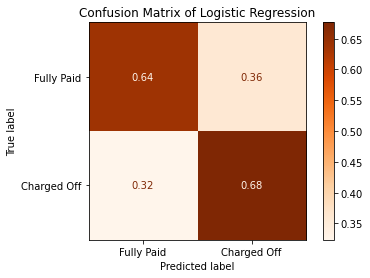

In [19]:
plot_confusion_matrix(
    xgb_v2, X_down_test, y_down_test, cmap='Oranges', 
    normalize='true',
    display_labels=['Fully Paid','Charged Off'])
plt.title('Confusion Matrix of Logistic Regression')

In [20]:
pickle.dump(xgb_v2, open("loan_xgb.pkl", 'wb'))

In [21]:
X_down_test[:10]

,loan_amnt,term,int_rate,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,mort_acc,...,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w,application_type_Joint App
1786306,3000.0,36,30.94,79000.0,1.52,7.0,0.0,1671.0,13.3,0.0,...,0,0,0,0,0,0,0,0,1,0
1202688,30000.0,36,13.33,110000.0,12.21,10.0,1.0,17211.0,56.2,1.0,...,0,0,0,0,0,0,0,0,0,0
763365,5800.0,36,16.99,85000.0,17.02,17.0,3.0,8215.0,53.3,0.0,...,0,0,0,0,0,0,0,0,1,0
727991,5400.0,36,12.99,31680.0,16.21,33.0,0.0,2923.0,48.7,0.0,...,0,0,0,0,0,0,0,0,0,0
723333,12325.0,36,14.49,31000.0,28.88,17.0,0.0,15503.0,82.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1360342,13000.0,36,8.39,130000.0,4.51,15.0,0.0,10743.0,39.5,1.0,...,0,0,0,0,0,0,0,0,1,0
510352,30000.0,60,30.17,124000.0,25.69,25.0,0.0,114818.0,66.5,2.0,...,0,0,0,0,0,0,0,0,1,0
1663794,24000.0,60,14.99,83000.0,6.75,8.0,0.0,1411.0,3.9,2.0,...,0,0,0,0,0,0,0,0,1,0
1785688,2000.0,36,13.59,60000.0,0.80,6.0,0.0,1238.0,24.8,0.0,...,0,0,0,0,0,0,0,0,1,0
848124,15125.0,36,18.92,60000.0,4.36,6.0,0.0,4590.0,68.5,0.0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
loan.head()

,loan_amnt,term,int_rate,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,mort_acc,...,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w,application_type_Joint App
0,5000.0,36,10.65,24000.0,27.65,3.0,0.0,13648.0,83.7,2.0,...,0,0,0,0,0,0,0,0,0,0
1,2500.0,60,15.27,30000.0,1.00,3.0,0.0,1687.0,9.4,2.0,...,0,0,0,0,0,0,0,0,0,0
2,2400.0,36,15.96,12252.0,8.72,2.0,0.0,2956.0,98.5,2.0,...,0,0,0,0,0,0,0,0,0,0
3,10000.0,36,13.49,49200.0,20.00,10.0,0.0,5598.0,21.0,2.0,...,0,0,0,0,0,0,0,0,0,0
4,3000.0,60,12.69,80000.0,17.94,15.0,0.0,27783.0,53.9,2.0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
for col in X_down_test.columns:
    print("'" + col + "',", end = '')

'loan_amnt','term','int_rate','annual_inc','dti','open_acc','pub_rec','revol_bal','revol_util','mort_acc','pub_rec_bankruptcies','fico','earliest_cr_line_y','sub_grade_A2','sub_grade_A3','sub_grade_A4','sub_grade_A5','sub_grade_B1','sub_grade_B2','sub_grade_B3','sub_grade_B4','sub_grade_B5','sub_grade_C1','sub_grade_C2','sub_grade_C3','sub_grade_C4','sub_grade_C5','sub_grade_D1','sub_grade_D2','sub_grade_D3','sub_grade_D4','sub_grade_D5','sub_grade_E1','sub_grade_E2','sub_grade_E3','sub_grade_E4','sub_grade_E5','sub_grade_F1','sub_grade_F2','sub_grade_F3','sub_grade_F4','sub_grade_F5','sub_grade_G1','sub_grade_G2','sub_grade_G3','sub_grade_G4','sub_grade_G5','home_ownership_OTHER','home_ownership_OWN','home_ownership_RENT','verification_status_Source Verified','verification_status_Verified','purpose_credit_card','purpose_debt_consolidation','purpose_educational','purpose_home_improvement','purpose_house','purpose_major_purchase','purpose_medical','purpose_moving','purpose_other','purpo

In [3]:
load_clf = pickle.load(open('loan_xgb.pkl', 'rb'))

In [8]:
from xgboost import plot_importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

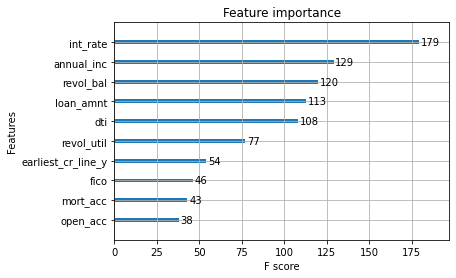

In [10]:
plot_importance(load_clf, max_num_features=10)